# Importing Libraries

In [3]:
import folium
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
from folium import Rectangle
from shapely.geometry import Point, Polygon
from rasterio.warp import transform_bounds

# Importing Data Sources

In [4]:
# Free WiFi range polygon shapefile
wifi_range_gdf = gpd.read_file('free_wifi_range/free_wifi_range.shp')

# Christchurch POIs point map shapefile
poi_gdf = gpd.read_file('chch_poi/Find_Christchurch_Feature_Data_(OpenData).shp')

# Georeferenced free WiFi map GeoTIFF
with rio.open('georef_free_wifi_map.tiff') as src:
    bounds = src.bounds
    blue = src.read(1)
    red = src.read(2)
    green = src.read(3)
    wifi_map = np.dstack((blue, green, red))
    wgs84_bounds = transform_bounds(src.crs, 'EPSG:4326', *bounds) # Image Bounds needs to be EPSG:4326 as this seems to be the Folium CRS
    folium_bounds = [
        [wgs84_bounds[1], wgs84_bounds[0]], 
        [wgs84_bounds[3], wgs84_bounds[2]]
    ]

# Data Filtering

In [5]:
# Christchurch Central City bounds coordinates
min_lat = -43.519478
max_lat = -43.539756
min_lon = 172.651032
max_lon = 172.612417

# Create a bounding box polygon of Christchurch Central City using above coords
bounding_box_geom = Polygon(
    [
        [max_lon, min_lat], # Bottom right corner
        [max_lon, max_lat], # Top right corner
        [min_lon, max_lat], # Top left corner
        [min_lon, min_lat]  # Bottom left corner
    ]
)

# Convert bounding box polygon geometry to GeoDataFrame to be able to use GeoPandas boolean overlay
# Needs to be in EPSG:4326 not EPSG:2193 as this seems to be the Folium CRS
bounding_box_gdf = gpd.GeoDataFrame(index=[0], crs='EPSG:4326', geometry=[bounding_box_geom])

# Filter out POIs that are outside of Christchurch Central City by using intersection overlay on bounding box & POI GeoDataFrame
# Filtering out irrelevant points helps with reducing compute time
# Again, needs to be in EPSG:4326 not EPSG:2193
central_poi_gdf = gpd.overlay(poi_gdf.to_crs("EPSG:4326"), bounding_box_gdf, how='intersection')

# Remove POIs points that fall within the free WiFi range polygon by using difference overlay
# Result is a GeoDataFrame of uncovered POIs in the city centre
uncovered_central_poi_gdf = gpd.overlay(central_poi_gdf, wifi_range_gdf.to_crs("EPSG:4326"), how='difference')

# Data Processing

### Grid Size
Set the grid size here.

In [6]:
# Adjust the size of the grid
grid_size = 20

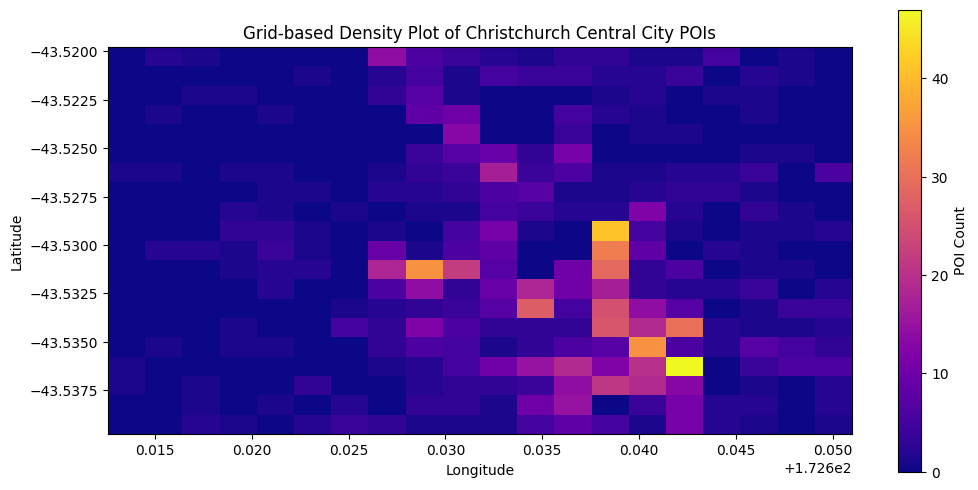

In [7]:
# Creating numpy arrays from result POI GeoDataFrame to hold the POIs point coordinates.
# Need to convert to arrays because numpy histogram function doesnt take GeoDataFrames
lon_array = uncovered_central_poi_gdf['geometry'].apply(lambda point: point.x).to_numpy()  # Extract only longitude (x) coordinates
lat_array = uncovered_central_poi_gdf['geometry'].apply(lambda point: point.y).to_numpy()  # Extract only latitude (y) coordinates

# Create 2D histogram (grid) to highlight the POI density (number of POIs in the cell)
poi_density, lon_edges, lat_edges = np.histogram2d(lon_array, lat_array, bins=grid_size)

# Plot the POI density per cell
plt.figure(figsize=(12, 6))
plt.imshow(
    poi_density.T, 
    origin = 'lower', 
    cmap = 'plasma', 
    interpolation = 'nearest', 
    extent = [
        lon_edges[0], 
        lon_edges[-1], 
        lat_edges[0], 
        lat_edges[-1]
    ]
)
plt.colorbar(label='POI Count')
plt.title('Grid-based Density Plot of Christchurch Central City POIs')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

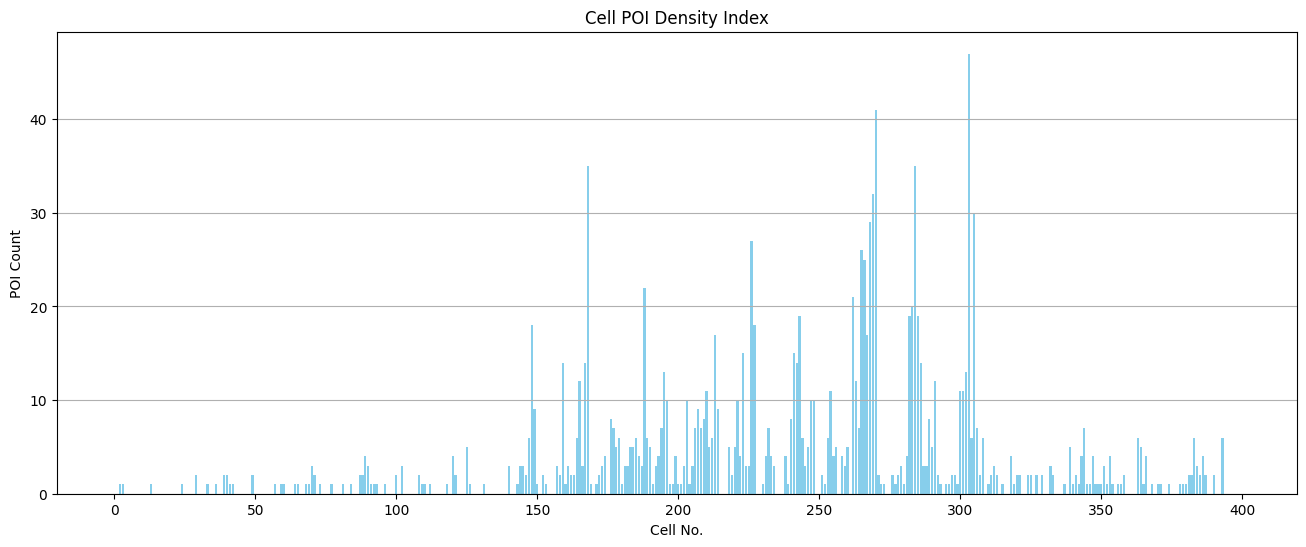

In [8]:
# Flatten the density array and create cell indices
poi_density_flat = poi_density.flatten()
cell_indices = np.arange(len(poi_density_flat))

# Plotting the density
plt.figure(figsize=(16, 6))
plt.bar(cell_indices, poi_density_flat, color='skyblue')
plt.xlabel('Cell No.')
plt.ylabel('POI Count')
plt.title('Cell POI Density Index')
plt.grid(axis='y')
plt.show()

### New WiFi Ranges Count
Set the number of new WiFi ranges here.

In [9]:
new_wifi_ranges_count = 20

In [10]:
# Find the cell indices of the top 20 densities
top_cells_flat_indices = np.argsort(poi_density.ravel())[-new_wifi_ranges_count:]

# Find the x and y cell coords of the top 20 densities
top_cells_unravel = np.unravel_index(top_cells_flat_indices, poi_density.shape)

# Combine the x and y cell coords/indices into a list of tuples
top_cells_indices = list(zip(top_cells_unravel[0], top_cells_unravel[1]))

In [11]:
# Create a dictionary to store POI points in each cell
cell_pois = {}

# Populate the dictionary
for lat, lon in zip(lat_array, lon_array):
    for i in range(len(lat_edges) - 1):
        for j in range(len(lon_edges) - 1):
            # Check if the POI is within the bounds of the cell
            if (lon_edges[i] <= lon < lon_edges[i + 1]) and (lat_edges[j] <= lat < lat_edges[j + 1]):

                # If cell is not in the cell, initialise list
                if (i, j) not in cell_pois:
                    cell_pois[(i, j)] = []

                # Add POI as Shapely point as tuple to dict
                cell_pois[(i, j)].append(Point(lat, lon))

In [12]:
top_cells_centroids = []

# Calculate the centroids of the densest cells
for i, j in top_cells_indices:
    # Get the list of POIs in the current cell
    pois_in_cell = cell_pois.get((i, j), [])

    # If cell is not empty
    if pois_in_cell:
        # Calculate the centroid of the POIs
        centroid_lat = sum(point.y for point in pois_in_cell) / len(pois_in_cell)
        centroid_lon = sum(point.x for point in pois_in_cell) / len(pois_in_cell)

        # Record centroid point
        top_cells_centroids.append(Point(centroid_lat, centroid_lon))

# Visualise Data
Grid cells & Smart City Free WiFi map layers are hidden be default.


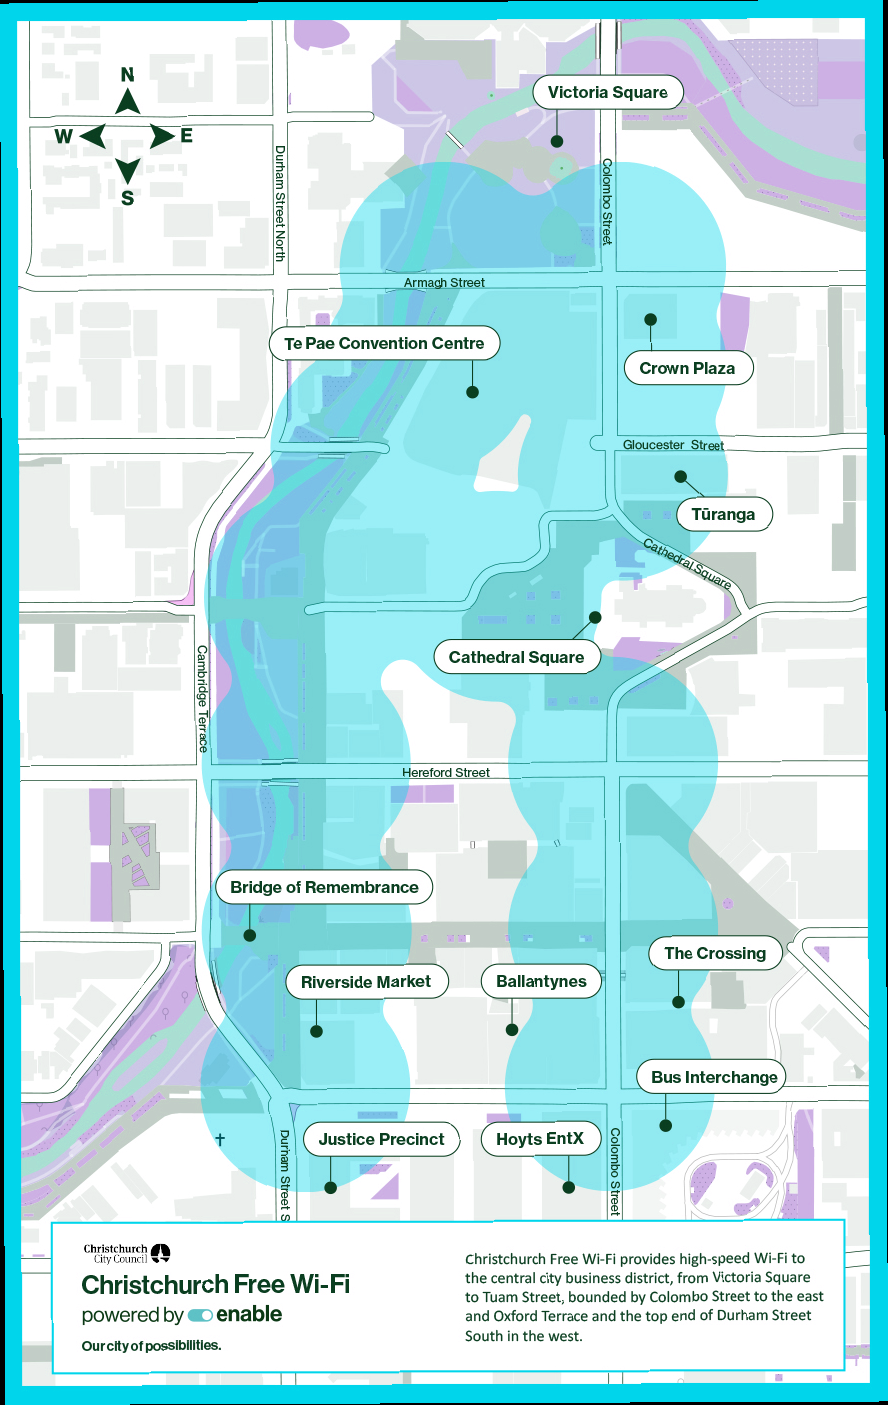

In [13]:
# Create the base map centered on the city centre
m = folium.Map(location=[-43.5291, 172.6314], zoom_start=12, control_scale=True)

# Group POIs together
poi_group = folium.FeatureGroup(name='Points of Interest (POIs)')

# Add red dots for each POI
for index, row in uncovered_central_poi_gdf.iterrows():
    name = row["Name"]
    poi = row["geometry"]
    address = row["AddressHTM"]

    folium.CircleMarker(
        location=[poi.y, poi.x],  # Access coordinates
        radius=3,
        color='red',
        fill=True,
        fill_opacity=0.5,
        popup=f'{name} {address}',
    ).add_to(poi_group)

# Group grid cells together
grid_group = folium.FeatureGroup(name='Density Grid Cells', show=False)

# Add rectangles representing grid cells
for i in range(len(lon_edges) - 1):
    for j in range(len(lat_edges) - 1):
        # Define the corners of each cell
        bottom_left = [
            lat_edges[j], 
            lon_edges[i]
        ]
        top_right = [
            lat_edges[j+1], 
            lon_edges[i+1]
        ]
        
        # Add grid cell to group
        folium.Rectangle(
            bounds = [bottom_left, top_right],
            color = 'blue',
            fill = True,
            fill_opacity = 0.1,
            weight = 1
        ).add_to(grid_group)

        # Calculate the center of the cell (position to place the POI count)
        cell_center = [
            (lat_edges[j] + lat_edges[j + 1]) / 2, 
            (lon_edges[i] + lon_edges[i + 1]) / 2
        ]
        
        # Get the number of POIs in the current cell
        poi_count = 0
        if (i, j) in cell_pois:
            poi_count = len(cell_pois[(i, j)])

        # Show the POI count at the center of the cell
        folium.Marker(
            location = cell_center,
            icon = folium.DivIcon(
                html = f'<div style="font-size: 12pt; color: blue;">{poi_count}</div>'
            )
        ).add_to(grid_group)

# Add circles for the top density cells
circle_group = folium.FeatureGroup(name='Proposed New Free WiFi Areas')

# Add circles for the top density cells based on their centroids
for centroid in top_cells_centroids:
    # Add a circle at the geometry centroid
    folium.Circle(
        location=[centroid.y, centroid.x],
        radius=75,  # Radius in meters
        color='orange',
        fill=True,
        fill_opacity=0.5,
        weight=2,
        popup=f'New WiFi Point \n {centroid.y}, {centroid.x}'
    ).add_to(circle_group)

# Add grid-based densities to the map
grid_group.add_to(m)

# Add proposed new free WiFi ranges to the map
circle_group.add_to(m)

# Convert GeoDataFrame to GeoJSON then adding as a layer to the map
folium.GeoJson(wifi_range_gdf, name='Smart City Free WiFi Area').add_to(m)

# Add Christchurch Central City POIs to the map
poi_group.add_to(m)

# Add georeferenced Smart City Free WiFi image to the map
folium.raster_layers.ImageOverlay(
    image=wifi_map, 
    opacity=0.8,
    bounds=folium_bounds,
    name="Smart City Free WiFi Map",
    show=False
).add_to(m)

# Add Layer Control to the map
folium.LayerControl(collapsed=False).add_to(m)

# Fit the map to the bounding box
m.fit_bounds([[min_lat, min_lon], [max_lat, max_lon]])

# Display the map
m

# Export Data

In [14]:
# Export the map as an interactable HTML map
m.save('Proposed_New_Free_WiFi_Areas.html')